In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
from collections import defaultdict

12mer-kd
0.10771


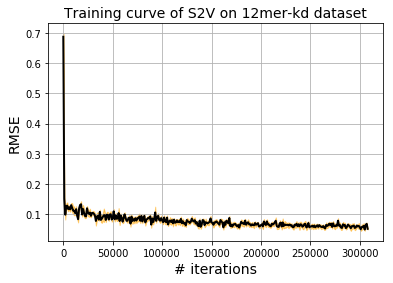

aft1
0.02914


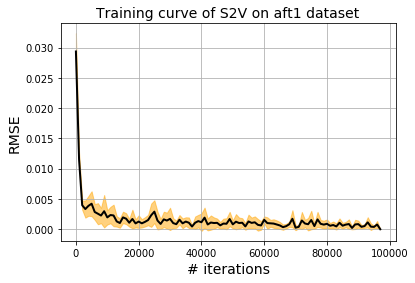

In [30]:
def read_log(logfile):
    train_iter = []
    train_rmse = []
    test_iter = []
    test_rmse = []
    test_auc = []
    cur_iter = 0
    with open(logfile, 'r') as f:
        for row in f:
            if 'train iter' in row:
                row = row.split('\t')
                cur_iter = int(row[0].split('=')[-1])
                rmse = float(row[2].split(':')[1].strip())
                train_iter.append(cur_iter)
                train_rmse.append(rmse)
            elif 'test rmse' in row:
                rmse = float(row.split('\t')[1].split(':')[-1].strip())
                test_iter.append(cur_iter)
                test_rmse.append(rmse)
                if 'test auc' in row:
                    auc = float(row.split('\t')[-1].split(':')[-1].strip())
                    test_auc.append(auc)
            elif 'testing iter' in row:
                cur_iter = int(row.split()[-1])
            else:
                continue
    if len(test_auc):
        return train_iter, train_rmse, test_iter, test_auc
    else:
        return train_iter, train_rmse, test_iter, test_rmse

# result_root = os.path.expanduser('~') + '/scratch/results/DREAM5'
result_root = os.path.expanduser('~') + '/scratch/results/kd_prediction_gnn'

if 'DREAM5' in result_root:
    metric = 'auc'
else:
    metric = 'rmse'
datasets = os.listdir(result_root)

for data in datasets:
    data_folder = result_root + '/' + data
    if not os.path.isdir(data_folder):
        continue
    print(data)
    configs = os.listdir(data_folder)
    best_metric = 1000000
    best_train = None
    best_test = None
    for config in configs:
        result_folder = data_folder + '/' + config
        if not os.path.isdir(result_folder):
            continue
        logs = glob.glob(result_folder + '/log*.txt')
        train_logs = defaultdict(list)
        test_logs = defaultdict(list)
        s = 0.0
        for log in logs:
            train_iter, train_rmse, test_iter, test_metric = read_log(log)
            for i in range(len(train_iter)):
                train_logs[train_iter[i]].append(train_rmse[i])
            for i in range(len(test_iter)):
                test_logs[test_iter[i]].append(test_metric[i])
            if metric == 'auc':
                s -= np.max(test_metric)
            else:
                s += np.min(test_metric)
        s /= len(logs)
        if s < best_metric:
            best_metric = s
            best_train = train_logs.copy()
            best_test = test_logs.copy()
    print(best_metric)
    m = []
    idxes = []
    s = []
    for cur_iter in best_train:
        mean = np.mean(best_train[cur_iter])
        if len(best_train[cur_iter]) > 1:
            std = np.std(best_train[cur_iter])
        else:
            std = 0
        m.append(mean)
        s.append(std)
        idxes.append(cur_iter)
    m = np.array(m)
    s = np.array(s)
    idxes = np.array(idxes)
    r = range(0, len(m), 10)
    m = m[r]
    s = s[r]
    idxes = idxes[r]
    plt.plot(idxes, m, 'k-', linewidth=2)
    plt.fill_between(idxes, m - s, m + s, alpha=0.5, color='orange')
    plt.grid()
    plt.xlabel('# iterations', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.title('Training curve of S2V on %s dataset' % data, fontsize=14)
    ax = plt.gca()
#     for item in (ax.get_xticklabels() + ax.get_yticklabels()):
#         item.set_fontsize(12)
    plt.savefig('%s.pdf' % data)
    plt.show()
